# This is a part of the **practical exercise** on uncertainty for dermatoscopy classification. Your task is to go through this tutorial and fill in missing code and answer the questions.

---

First, as usual, we load needed libraries.

---


In [3]:

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from tqdm import tqdm
from torchvision.transforms import ToTensor, Lambda

import numpy as np

In [4]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=5aa064a2bde6c4906d12f585653ddd0434873ea6fe4d559f1d977d1f99097867
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


---

Now, let's load the dermatoscopy dataset from MedMNIST.

---



In [5]:
import medmnist
from medmnist import INFO, Evaluator

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
data_flag = 'dermamnist'
info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

train_set = DataClass(split='train', transform=data_transform, download=True)
test_set = DataClass(split='test', transform=data_transform, download=True)
train_set

100%|██████████| 19725078/19725078 [00:02<00:00, 7941487.70it/s] 


Using downloaded and verified file: /root/.medmnist/dermamnist.npz


Dataset DermaMNIST (dermamnist)
    Number of datapoints: 7007
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0


---

**Q1:** Next, we define objects of *DataLoader* class for training and testing splits. And we also define our model. Here it gets more challenging.

In the cell below you need to:

- load a resnet18 pretrained on ImageNet network from PyTorch
- add a Dropout layer to the last fully-connected layer with 25% probability of neurons to be zeroed
- change the last layer of the resnet18 such that it outputs 7 classes (the number of classes in the dermatoscopy dataset) instead of 1000 classes (as it is in the pretrained network)
- freeze all the layers except the last one, as we are gonna fine tune in the next step our pretrained network on the medical dataset

---

In [6]:
train_batch_size = 40
test_batch_size = 3

train_loader = DataLoader(
    train_set,
    batch_size=train_batch_size,
    num_workers=1,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=test_batch_size,
    num_workers=1,
    pin_memory=True,
)
####

model = resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.25),
    nn.Linear(num_ftrs, 7)
)

for name, param in model.named_parameters():
    if "fc" not in name:
        param.requires_grad = False

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 67.1MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  


---



Hope you made it work! Now we are gonna fine-tune the model (the last layer of it to be more precise).  

---

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss = []
model.train()

for epoch in range(5):  # loop over the dataset 5 times to fine-tune the last layer

    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels.squeeze(1))
        loss.backward()
        optimizer.step()

print('\n Finished training')

100%|██████████| 176/176 [00:12<00:00, 14.23it/s]


 Finished training


**Q2:** What the heck? We got an error (`RuntimeError: 0D or 1D target tensor expected, multi-target not supported`).

Any idea how we can fix it?



*   Each element 'labels' tensor should be a single integer representing the class index (not a one-hot encoded vector, just the index).
*   To fix this, we need to make sure that labels is a 1D tensor. We can remove the second dimension using the squeeze(1) method, which removes dimensions of size 1 from the tensor.

---

Let's test the classification accuracy of our model.

**Q3:** Please fill in the missing code below. You need to loop over the test set and compute how many times the trained network predicts the class
correctly.

---

In [9]:
#  set model state to eval() for running the inference
model.eval()

correct = 0
total = 0
correcti = [0 for i in range(10)]
totali = [0 for i in range(10)]

with torch.no_grad():
  for images, labels in tqdm(test_loader):

      outputs = model(images)

      # max returns (value ,index)
      _, predicted = torch.max(outputs, 1)
      total += outputs.size(0)
      correct += (predicted == labels.squeeze(1)).sum().item()

      for i in range(outputs.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                correcti[label] += 1
            totali[label] += 1

  accuracy = 100 * correct / total
  print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

  for i in range(7):
        acc = 100.0 * correcti[i] / totali[i]
        print(f'Accuracy of classes[{i}]: {acc} %')



100%|██████████| 669/669 [00:14<00:00, 46.34it/s]

Accuracy of the network on the test images: 69.68%
Accuracy of classes[0]: 18.181818181818183 %
Accuracy of classes[1]: 12.62135922330097 %
Accuracy of classes[2]: 19.545454545454547 %
Accuracy of classes[3]: 0.0 %
Accuracy of classes[4]: 11.659192825112108 %
Accuracy of classes[5]: 96.64429530201342 %
Accuracy of classes[6]: 24.137931034482758 %


---

The accuracy is ok, but not mindblowing. Thus it would be useful, as discussed in the lecture, to know how confident our model is. Let's use Monte Carlo dropout to find out. We now run 1000 forward passes and look at the distribution of the predictions.

---

In [20]:
# Enable dropout during inference
def enable_dropout(model):
    for module in model.modules():
        if module.__class__.__name__.startswith('Dropout'):
            module.train()

enable_dropout(model)

samples = 1000
preds = []
image = next(iter(test_loader))

for idx in range(samples):
    preds.append(model(image[0]).clone().detach().numpy())
preds = np.array(preds)

In [21]:
pred_class = []
for idx in range(preds.shape[0]):
    pred_class.append(np.argmax(preds[idx],1))

---

Now, we look at the results.

---



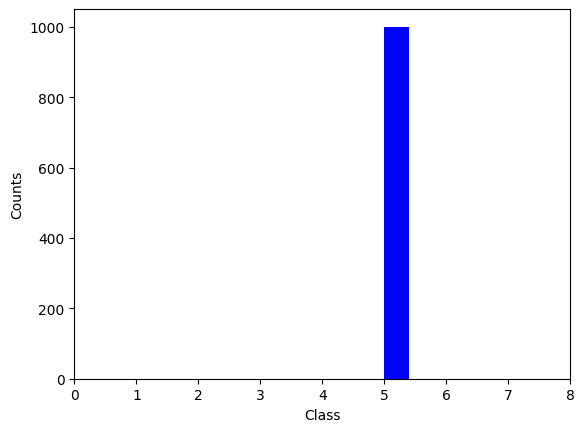

In [22]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist([x[0] for x in pred_class], facecolor='b', width = 0.4)
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim([0,8])
plt.show()

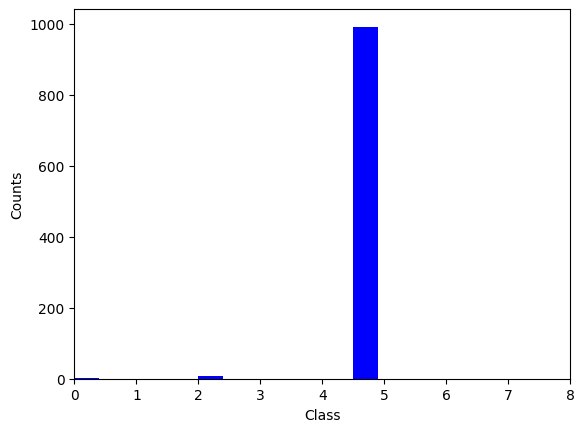

In [23]:
n, bins, patches = plt.hist([x[1] for x in pred_class], facecolor='b', width = 0.4)
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim([0,8])
plt.show()

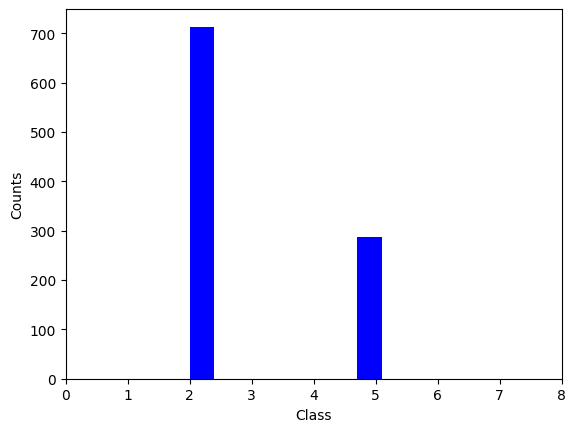

In [24]:
n, bins, patches = plt.hist([x[2] for x in pred_class], facecolor='b', width = 0.4)
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim([0,8])
plt.show()

---

Hmm... each time, we predicted the same class 1000 times, but we expected the dropout to provide some distribution of predictions. Suspicuous...

**Q4:** Is there a catch? Please write your thoughts on why we do not see a distribution and whether we could fix it somehow.


*   Monte Carlo Dropout is a technique to estimate model uncertainty by enabling dropout during inference, which is not the default behavior in PyTorch.

*   If Monte Carlo dropout was not activated, then the lack of variation in predictions across the 1000 forward passes is expected. Without dropout being active during inference, the network behaves deterministically, and hence, we will get the same prediction every time for a our input.

*   Since dropout was not activated, each forward pass through the network would be deterministic, resulting in the same prediction every time as we can see in the figures.

*   To fix this issue, we implemeted enable_dropout to enable dropout during inference


---